# COGS 108 - Final Project 

# Overview

In this project, I took in a dataset of yelp information regarding certain restaurants and paired them up with their respective health inspection information. From there I cleaned the data to obtain relevant information that may come in handy when trying to predict a restaurant's health score. I ran a multivariate regression using that information and found that the most significant predictor of health scores was location (zipcodes).

# Name & GitHub

- Name: Benson Vuong
- GitHub Username: Benson272

# Research Question

Can we use a restaurant's yelp page to obtain an accurate predicted health inspection score, and if we can, what features of the restaurant is most important in deciding such a prediction? From the yelp page, relevant information that I can measure that may relate to health score include zipcodes, pricing of restaurant, and the ratings. 

## Background and Prior Work

While there are underlying patterns in the restaurants health inspectors check out, there is a bit of randomness at times when selecting a restaurant to inspect <sup>1</sup>. As such, it would be beneficial if health workers knew before hand which restaurants are at risk of having low inspection scores. If they knew, it would be easier to target those restaurant and give them the attention required instead of inspecting restaurants that pose little health risk. As such, a solution would be to have something that can predict the score of a restaurant given some information about it, and from there inspectors can deicde which restaurants they should visit first. For reference, the score needed to be in the highest ranking is a score greater than 90. And an exceptionally good score would be one >= 95 <sup>2</sup>.

Predicting a restaurant's health score is actually a problem people are already tackling<sup>3</sup>. In fact, some of the solutions implemented by others have a very similar structure to the techniques we learned in class and that I am going to implement here. One such way is to take certain features of a restaurant and use them in regression to predict the health inspection score<sup>4</sup>. Once a score is obtained, proper action can be taken to better ensure the saftey of the public. 

References (include links):
- 1)https://blog.typsy.com/how-do-health-inspections-work
- 2)https://www.sfdph.org/dph/EH/Food/Score/default.asp
- 3)https://www.drivendata.org/competitions/5/keeping-it-fresh-predict-restaurant-inspections/page/28/
- 4)https://www.drivendata.org/competitions/5/keeping-it-fresh-predict-restaurant-inspections/page/28/

# Hypothesis


Some feature that may come in handy during the prediction process are location, price, and ratings. Out of those three, I believe that the most significant predictor will be the price. My justification for this is that places with cheaper prices tend to be more untidy and unkempt, and on the flip side more expensive restaurants tend to be fancier and cleaner, as they have a reputation to uphold. After price, the next best predictor would be location because restaurants that come from the same area usually have similar environment (although that may not always be true). The reason I say ratings would be the worst in predicting scores is because people may give a really high rating for a place based solely on the value of the food or the flavor of it, both of which have no relation to a health inspection score. 

# Dataset(s)

- Dataset Name:Yelp academic dataset business
- Link to the dataset:https://www.kaggle.com/yelp-dataset/yelp-dataset/data?select=yelp_academic_dataset_business.json
- Number of observations:11177<br>
This dataset comes from yelp and includes a list of restaurants with information that can be found on their yelp page. Some of the information included is rating, address. 
<br>

- Dataset Name:Yelp.csv
- Link to the dataset: provided by instructor
- Number of observations:2874<br>
This dataset was provided by the instructor and includes similar information as the previous dataset on yelp. Contains features such as restaurant name, address, price, ratings, zipcode
<br>

- Dataset Name:inspections.csv
- Link to the dataset:provided by instructor
- Number of observations:18466<br>
This dataset was provided by the instructor. It is a dataset that list a restaurant along with its inspection summary. Information from the dataset include: the restaurant, when the inspection happened, what score they received, their address. There are many other information relating to health inspections, but the ones listed above are the most important for this project.
<br>

Upon retrieval, all the data sets are separated entities, so to remedy that I have to combine them into one dataframe so I can match up information. To do this I plan on using the address of the restaurants, as that should be consistent throughout the datasets. That also means that I should not be getting repeat restaurants because one restaurant has one address. 

# Setup

In [1]:
import pandas as pd
import numpy as np
import patsy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import Image 


inspections_df = pd.read_csv("inspections.csv")
yelp_original_df = pd.read_csv("yelp.csv")
yelp_additional_df = pd.read_json("yelp_additional_reviews.json", lines=True)
zip_df = pd.read_csv("zipcodes.csv")


# Data Cleaning

1. The additional yelp dataset I found does not have the price listed as a column, but instead is stored in a column called attributes, which is a dictionary that has a key as price. I have to extract that price value from the dictionary and put it into its own column
2. The original yelp dataset has prices listed in the dollar sign symbol, so I had to convert those to numbers 
3. Only take the relevant information from both yelp datasets
4. Rename columns to have informative, concise naming
5. Take all the yelp dataset and compare it to the inspections dataset. Match up the restaurants with each other by using the address of the establishment. 
6. remove repeating entries from merge in previous steps (there are multiple inspections for the same address, and that got carried over, but we only need 1 instance of the restaurant)
7. Take only relevant columns from the merged dataset

In [2]:
#function to convert additonal yelp data to have price
def convert_attribute_to_price(series):
    if series == None:
        return -1
    price = series.get('RestaurantsPriceRange2')
    
    if type(price) == str:
        if price == "None":
            return -1
        else:
            return int(price)
    return price

yelp_additional_df['price'] = yelp_additional_df['attributes'].apply(convert_attribute_to_price)
yelp_additional_df = yelp_additional_df[yelp_additional_df.price.notnull()]
yelp_additional_df = yelp_additional_df[yelp_additional_df['price'] > 0]

In [3]:
#function to convert original yelp data to have numerical price
def convert_price_to_int(price):
    if price == "$":
        return 1
    elif price == "$$":
        return 2
    elif price == "$$$":
        return 3
    elif price == "$$$$":
        return 4
    else:
        return None
    
yelp_original_df['price'] = yelp_original_df['price'].apply(convert_price_to_int)
yelp_original_df = yelp_original_df[yelp_original_df['price'].notna()]

In [4]:
#gets the relevant columns from the yelp dataframes
yelp_original_df = yelp_original_df[['rating', 'review_count', 'address1', 'zip_code', 'price']]
yelp_additional_df = yelp_additional_df[['stars', 'review_count', 'address', 'postal_code', 'price']]

#rename the columns to have consistent naming
yelp_original_df = yelp_original_df.rename(columns={"address1":"address", "zip_code":"zipcode"})
yelp_additional_df = yelp_additional_df.rename(columns={"stars":"rating", "postal_code":"zipcode"})

#combines the two yelp dataframes
yelp_df = yelp_original_df.append(yelp_additional_df)

In [5]:
#get the restaurants that have yelp reviews AND inspections
restaurants_df = inspections_df.merge(yelp_df, left_on='address1', right_on='address')
restaurants_df = restaurants_df.sort_values(by=['score'], ascending = True)
restaurants_df['score']
restaurants_df = restaurants_df.drop_duplicates(subset ="address1", keep = 'first') 

#gets the importnat columns, namely: name_x, address1, score, rating, review_count, zip_code, price
restaurants_df = restaurants_df[['address1', 'score', 'rating', 'review_count', 'zipcode', 'price']]

#we finished using address to match restaurants, so we no longer need it
restaurants_df.drop(['address1'], axis=1)

,score,rating,review_count,zipcode,price
1004,77.5,2.0,44,27612,2.0
130,81.5,3.0,57,27609,2.0
19,83.0,3.5,237,27609,2.0
1485,84.5,4.5,34,27511,1.0
879,85.5,2.5,79,27511,2.0
...,...,...,...,...,...
1598,97.5,4.0,10,27511,2.0
1322,97.5,2.0,1,27529,2.0
39,97.5,3.5,35,27607,1.0
1284,98.0,2.0,2,27518,2.0


# Data Analysis & Results

### Load Visualization of what the zipcode districts look like ###
The zipcodes were grouped together based on geographical location

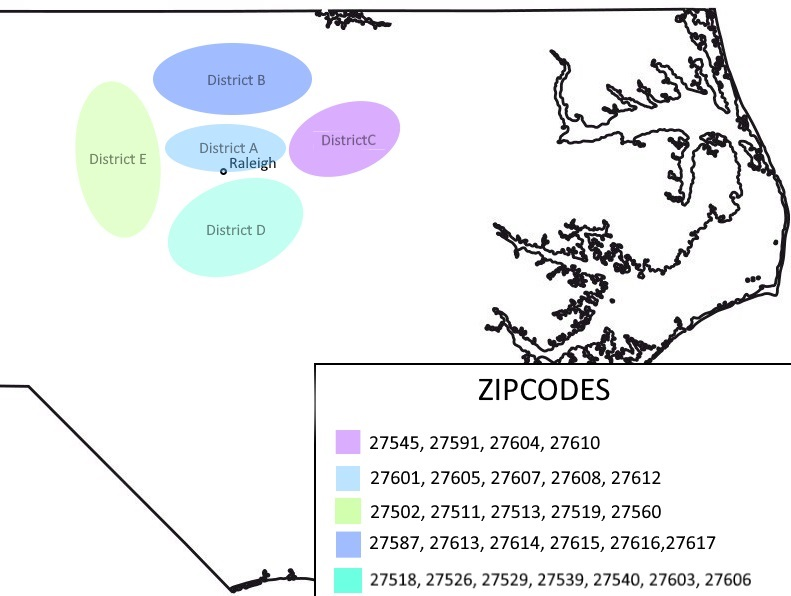

In [6]:
#create grouping of geographically similar zipcodes
districtA = [27601, 27605, 27607, 27608, 27612]
districtB = [27587, 27613, 27614, 27615, 27616, 27617]
districtC = [27545, 27591, 27604, 27610]
districtD = [27518, 27526, 27529, 27539, 27540, 27603, 27606]
districtE = [27502, 27511, 27513, 27519, 27560]

#create dataframe for each specific district
districtA_df = restaurants_df[restaurants_df['zipcode'].isin(districtA)]
districtB_df = restaurants_df[restaurants_df['zipcode'].isin(districtB)]
districtC_df = restaurants_df[restaurants_df['zipcode'].isin(districtC)]
districtD_df = restaurants_df[restaurants_df['zipcode'].isin(districtD)]
districtE_df = restaurants_df[restaurants_df['zipcode'].isin(districtE)]

#displays the districts
Image('district_outline.jpg')

## Graphing the number of good health scores in a district ## 
Graph out the number of good health inspection scores within a district to see whether certain districts have a higher number of good health scores than others. This will help motivate the prediction process by showing us which districts has a better history of having good health scores. *From here on, whenever I meantion "good score" I am refering to one greater than or equal to 95*

In [7]:
#for each district, show how many restaurants are doing well in their health score
district_num_good_score = []
district_num_bad_score = []
district_num_score = []

i = 0;
for series in [districtA_df['score'], districtB_df['score'], districtC_df['score'], districtD_df['score'], districtE_df['score']]:
    count_good_score = series[series >= 95].count()
    district_num_good_score.insert(i,count_good_score)
    district_num_bad_score.insert(i,series.count() - count_good_score)
    district_num_score.insert(i,series.count())
    i+=1


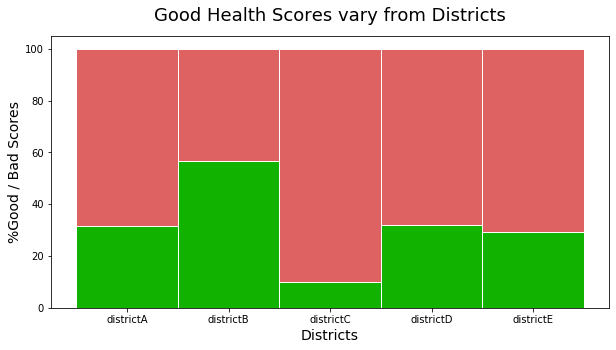

In [8]:
#graph the relation between good scores and location
df = pd.DataFrame({
    'District': ['districtA', 'districtB', 'districtC', 'districtD', 'districtE'],
    'Good_Score' : district_num_good_score,
    'Bad_Score' : district_num_bad_score
})


# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# positions of the left bar
bar_l = [i for i in range(len(df['District']))] 

tick_pos = [i for i in bar_l] 

# Create the total score for each district
totals = [i+j for i,j in zip(df['Good_Score'], df['Bad_Score'])]

# Create the percentage of the total score
relative_good = [i / j * 100 for  i,j in zip(df['Good_Score'], totals)]

# Create the percentage of the total score
relative_bad = [i / j * 100 for  i,j in zip(df['Bad_Score'], totals)]


# Create a bar chart with good score percentage
ax.bar(bar_l, relative_good, label='Good Score', color='#12b300', width=1, edgecolor='white')

# Create a bar char with bad score percentage
ax.bar(bar_l, relative_bad, bottom=relative_good, label='Bad Score', color='#de6262', width=1, edgecolor='white')


# Sets the labels of the graph
plt.xticks(tick_pos, df['District'])
ax.set_ylabel("%Good / Bad Scores", fontsize=14)
ax.set_xlabel("Districts", fontsize=14)
plt.title("Good Health Scores vary from Districts", horizontalalignment = "center", fontsize=18, pad = 15)


plt.show()

### Results of plotting health scores for districts ###
From the visual, it seems that certain districts, namely B and C, have widely varying good health scores comparitively speaking. The higher the green bar, the higher percentage of good health scores the district had. So the graph suggests that restaurants in districtB have higher chance of getting a good predicted score and restuarants in district C may have a lower chance of getting a good predicted score

## Graphing the number of good health scores based on ratings ##
Ploting the number of good health scores for each rating of a restaurant (1.0 - 5.0 stars). Like with the zipcodes, plotting out the ratings may give a sense of a pattern for the nunber of good health scores given a restaurant's rating.

In [9]:
#counting the number of good and bad health scores for all ratings
ratings_num_good_score = []
ratings_num_bad_score = []
ratings_num_score = []

for i in np.linspace(1,5,9):
    ratings = restaurants_df[restaurants_df['rating'] == i]
    num_good = ratings[ratings['score'] >= 95]['score'].count()
    num_total = ratings['score'].count()
    num_bad = num_total - num_good
    ratings_num_good_score.insert(i,num_good)
    ratings_num_bad_score.insert(i,num_bad)
    ratings_num_score.insert(i,num_total)


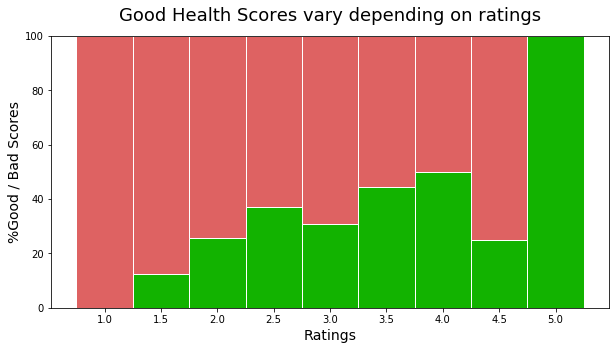

In [10]:
#graph the relation between good scores and ratings
df = pd.DataFrame({
    'Ratings': [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
    'Good_Score' : ratings_num_good_score,
    'Bad_Score' : ratings_num_bad_score
})


# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# positions of the left bar
bar_l = [i for i in range(len(df['Ratings']))] 

tick_pos = [i for i in bar_l] 

# Create the total score for each rating
totals = [i+j for i,j in zip(df['Good_Score'], df['Bad_Score'])]

# Create the percentage of the total score 
relative_good = [i / j * 100 for  i,j in zip(df['Good_Score'], totals)]

# Create the percentage of the total score
relative_bad = [i / j * 100 for  i,j in zip(df['Bad_Score'], totals)]


# Create a bar chart with good score percentage
ax.bar(bar_l, relative_good, label='Good Score', color='#12b300', width=1, edgecolor='white')

# Create a bar char with bad score percentage
ax.bar(bar_l, relative_bad, bottom=relative_good, label='Bad Score', color='#de6262', width=1, edgecolor='white')


# Sets the labels of the graph
plt.xticks(tick_pos, df['Ratings'])
ax.set_ylabel("%Good / Bad Scores", fontsize=14)
ax.set_xlabel("Ratings", fontsize=14)
plt.title("Good Health Scores vary depending on ratings", horizontalalignment = "center", fontsize=18, pad = 15)


plt.show()

### Results of plotting health scores for ratings ###
Like the previous graph, the way to interpret this is to look at the green bar, which represents the percentage of good health scores received given that the restaurant has a certain rating. Although there is no strict relation, there is a genral pattern that the lower the restaurant rating, the less likely it is for the restaurant to get a good health score. This can be seen by the upwards trend we see of the green bars as we move to higher ratings.

## Graphing the number of good health scores based on price ##
Now, we look at how price may be related to the health score of a restaurant. Plotting this may or may not reveal somehting about an underlying pattern relating price to health scores. 

In [11]:
#counts the number of good/bad scores based on the pricing of the restaurant
price_num_good_score = []
price_num_bad_score = []
price_num_score = []

for i in range(1,3):
    price = restaurants_df[restaurants_df['price'] == i]
    num_good = price[price['score'] >= 95]['score'].count()
    num_total = price['score'].count()
    num_bad = num_total - num_good
    price_num_good_score.insert(i,num_good)
    price_num_bad_score.insert(i,num_bad)
    price_num_score.insert(i,num_total)
    

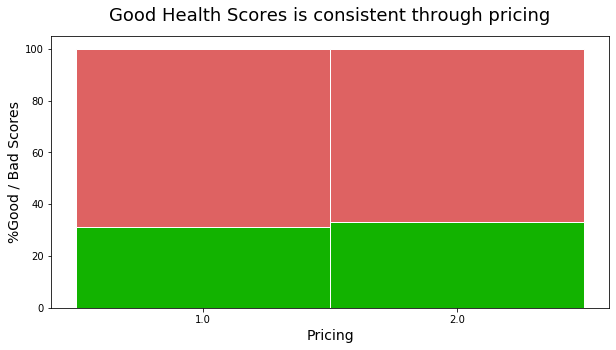

In [12]:
df = pd.DataFrame({
    'Price': [1.0, 2.0],
    'Good_Score' : price_num_good_score,
    'Bad_Score' : price_num_bad_score
})


# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# positions of the left bar
bar_l = [i for i in range(len(df['Price']))] 

tick_pos = [i for i in bar_l] 

# Create the total score for each pricing
totals = [i+j for i,j in zip(df['Good_Score'], df['Bad_Score'])]

# Create the percentage of the total score
relative_good = [i / j * 100 for  i,j in zip(df['Good_Score'], totals)]

# Create the percentage of the total score
relative_bad = [i / j * 100 for  i,j in zip(df['Bad_Score'], totals)]


# Create a bar chart with good score percentage
ax.bar(bar_l, relative_good, label='Good Score', color='#12b300', width=1, edgecolor='white')

# Create a bar char with bad score percentage
ax.bar(bar_l, relative_bad, bottom=relative_good, label='Bad Score', color='#de6262', width=1, edgecolor='white')


# Sets the labels of the graph
plt.xticks(tick_pos, df['Price'])
ax.set_ylabel("%Good / Bad Scores", fontsize=14)
ax.set_xlabel("Pricing", fontsize=14)
plt.title("Good Health Scores is consistent through pricing", horizontalalignment = "center", fontsize=18, pad = 15)


plt.show()

### Results of plotting health scores for pricing of restaurant ###
As the visual suggest, whether the pricing of a restaurant is considered `$` or `$$` does not have much impact on the health score rating (made evident by the similar height in the bars of both categories). It seems that both of them have a similar number of good inspection score, and thus price may not be as good as a predictor as I first anticipated. 

## Using multivariate linear regression ##
Now that we have an idea of what everything looks like and how the health inspection scores are distributed based on certain attributes, we can attempt to create a multivariate regression in hopes of obtaining information about the best predictor for a health score. I'm interested in seeing what the significant predictor is after seeing that price may not be a good predictor.

In [13]:
#function to convert zipcode to districts
def convert_zipcode_to_district(zipcode):
    if zipcode in districtA:
        return 'DistrictA'
    elif zipcode in districtB:
        return 'DistrictB'
    elif zipcode in districtC:
        return 'DistrictC'
    elif zipcode in districtD:
        return 'DistrictD'
    else:
        return 'DistrictE'

restaurants_df['zipcode'] = restaurants_df['zipcode'].apply(convert_zipcode_to_district) 

In [14]:
#convert ratings to be strings (categorical)
restaurants_df['rating'] = restaurants_df['rating'].apply(str)

In [15]:
#convert price to be strings (categorical)
restaurants_df['price'] = restaurants_df['price'].apply(str)

In [16]:
outcome, predictors = patsy.dmatrices('score ~ zipcode + rating + price', restaurants_df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     1.778
Date:                Tue, 09 Jun 2020   Prob (F-statistic):             0.0596
Time:                        20:12:27   Log-Likelihood:                -253.88
No. Observations:                 100   AIC:                             535.8
Df Residuals:                      86   BIC:                             572.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               95.5422 

The outcome of this regression is not what i expected. At first glance, it seems that ratings have a major impact on scoring, but after looking at the p-values, the one with the lowest one (districtB), seems to be a good predictor. The p values of the ratings seems a bit high. We would prefer not to have high o-values because a higher p value means there is a highger chance that the data was generated by random chance alone. That's why we want a small p-value, which by looking at the summary shows that districtB has a small one. By factoring the p-value, I would say districtB is a good predictor of score. 

# Ethics & Privacy

One ethical issue with this process may be the possibiliy that the predictor can give a false scoring of a restaurant and result in a worse scoring than they would have normaly received. This would be a problem for the restaurant, as it may deter customers from visiting. However, false scorings don't have to be a problem. The predictions made by this do not have to be released to the public, as it is only a guideline for health inspectors to choose which restaurants require more attention. As such, a false scoring won't pose much of a threat to the business of the restaurant. 

There may also be some bias with the restaurants in the data because there are more types of one restaurants than others. For example, There may be a lot more fast foods restaurant in the dataset than chinese restaurants. And this is because fast food restaurants are just more prevalent due to the size of the fast food industry. These sort of biases can affect the outcome of the prediction beacuse some restaurants may be more prone to recieving lower scores (for example a restaurant that has live seafood may score worse, as they require more care to keep sanitary and thus a simple slip up can result in a lower score).

I do not think that using these datasets is a violation of privacy because all these information about the restaurant should be public anyway.Since the majority of the data came from yelp (which is a public platform). It should be fine to use this information. However, to ensure nothing bad happens, I took out any revealing information such as the name of the restaurant as well as the adress.


# Conclusion & Discussion

The point of this project was to see whether or not a restaurant's yelp page can be a good indication of the health score the restaurant should receive. In the end, it turns out that some of the information from a yelp page do have some relation to the health scores. Given the regression summary above, it seems like the best predictor comes from looking at a restaurant's zipcode and the general area where the restaurant is. Although this was not what I originally expected, it was close to what i expected. 

This whole project is not entirely accurate, and the prediction should be taken as a guidance and not the full truth. This is because of the dataset used in the analysis. Though the starting dataset had a plethora of observation, the merging step filtered out a lot of those observation (whether because of repeating restaurants or unmatchable observation when merging yelp with inspections). In the end, the total number of observation dimished to about 100, which is not an ideal size for analysis. Because of this, I do believe the results from the analysis may have been skewed. 